# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть на датасете fashion-mnist
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть в схеме AlexNet на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [0]:
### Загрузка данных cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

**Посмотрим первое изображение для обучения:**

In [0]:
# Размер тензора
train_images[0].shape

(32, 32, 3)

In [0]:
# Метка
train_labels[0]

array([6], dtype=uint8)

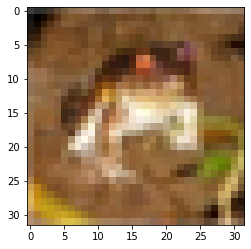

In [0]:
# Само изображение
plt.imshow(train_images[0])
plt.show()

**Обработаем массивы для обучения и теста:**
 - стандартизируем тензоры;
 - кодируем метки.

In [0]:
x_train = train_images.astype('float32') / 255
x_test = test_images.astype('float32') / 255

y_train = to_categorical(train_labels, 10) 
y_test = to_categorical(test_labels, 10) 

## Базовая модель

Блок генерации признаков:
 - первый свёрточный слой: 16 фильтров 3х3
 - второй свёрточный слой: 16 фильтров 3х3
 - слой пулинга через взятие максимума фильтром 2х2
 - слой дропаута для регуляризации весов
 
Блок классификации:
 - два полносвязных слоя по 64 нейрона
 - слой дропаута для регуляризации весов 
 - выходной слой с 10 нейронами

In [0]:
base_model = Sequential(name='base_model')

base_model.add(Conv2D(filters=16,
                      kernel_size=(3, 3),
                      activation='relu',
                      input_shape=(32, 32, 3),
                      padding='valid',
                      data_format='channels_last',
                      name='conv_1'))
base_model.add(Conv2D(filters=16,
                      kernel_size=(3, 3),
                      activation='relu',
                      data_format='channels_last',
                      name='conv_2'))
base_model.add(MaxPooling2D(pool_size=(2, 2),
                            data_format='channels_last',
                            name='pool_1'))
base_model.add(Dropout(rate=0.3, seed=0, name='drop_1'))

base_model.add(Flatten(name='flatten'))
base_model.add(Dense(64, activation='relu', name='dense_1'))
base_model.add(Dense(64, activation='relu', name='dense_2'))
base_model.add(Dropout(rate=0.3, seed=0, name='drop_2'))

base_model.add(Dense(10, activation='softmax', name='output'))

In [0]:
base_model.summary()

Model: "base_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                200768    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4

In [0]:
base_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [0]:
base_history = base_model.fit(x_train, y_train,
                              batch_size=40,
                              epochs=20,
                              validation_split=0.1,
                              use_multiprocessing=True,
                              verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 7s 161us/sample - loss: 1.5983 - acc: 0.4173 - val_loss: 1.2569 - val_acc: 0.5688
Epoch 2/20
45000/45000 [==============================] - 6s 141us/sample - loss: 1.2804 - acc: 0.5472 - val_loss: 1.1459 - val_acc: 0.5982
Epoch 3/20
45000/45000 [==============================] - 6s 140us/sample - loss: 1.1587 - acc: 0.5938 - val_loss: 1.0555 - val_acc: 0.6320
Epoch 4/20
45000/45000 [==============================] - 6s 140us/sample - loss: 1.0719 - acc: 0.6250 - val_loss: 0.9917 - val_acc: 0.6566
Epoch 5/20
45000/45000 [==============================] - 6s 140us/sample - loss: 1.0102 - acc: 0.6486 - val_loss: 0.9657 - val_acc: 0.6586
Epoch 6/20
45000/45000 [==============================] - 6s 139us/sample - loss: 0.9626 - acc: 0.6642 - val_loss: 0.9478 - val_acc: 0.6688
Epoch 7/20
45000/45000 [==============================] - 6s 139us/sample - loss: 0.9165 - acc: 0.6810 - val_lo

**Проверка модели**

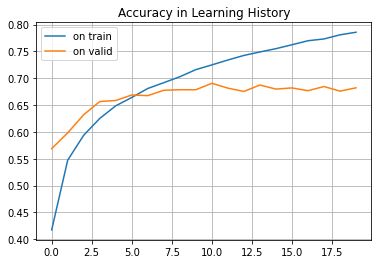

In [0]:
plt.plot(base_history.history['acc'], label='on train')
plt.plot(base_history.history['val_acc'], label='on valid')
plt.title('Accuracy in Learning History')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [0]:
test_loss, test_acc = base_model.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 100us/sample - loss: 1.0318 - acc: 0.6682


*Доля правильных ответов на тесте составляет примерно 66%.*

*Попробуем далее улучшить качество модели увеличением количества нейронов (в том числе от фильтров).*

## Увеличение количества нейронов

Блок генерации признаков:
 - первый свёрточный слой: 32 (было 16) фильтров 3х3
 - второй свёрточный слой: 32 (было 16) фильтров 3х3
 - слой пулинга через взятие максимума с ядром фильтром 2х2
 - слой дропаута для регуляризации весов
 
Блок классификации:
 - два полносвязных слоя по 256 (было 64) нейрона
 - слой дропаута для регуляризации весов 
 - выходной слой с 10 нейронами

In [0]:
model_mn = Sequential(name='model_mn')

model_mn.add(Conv2D(filters=32,
                    kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(32, 32, 3),
                    padding='valid',
                    data_format='channels_last',
                    name='conv_1'))
model_mn.add(Conv2D(filters=32,
                    kernel_size=(3, 3),
                    activation='relu',
                    data_format='channels_last',
                    name='conv_2'))
model_mn.add(MaxPooling2D(pool_size=(2, 2),
                          data_format='channels_last',
                          name='pool_1'))
model_mn.add(Dropout(rate=0.3, seed=0, name='drop_1'))

model_mn.add(Flatten(name='flatten'))
model_mn.add(Dense(256, activation='relu', name='dense_1'))
model_mn.add(Dense(256, activation='relu', name='dense_2'))
model_mn.add(Dropout(rate=0.3, seed=0, name='drop_2'))

model_mn.add(Dense(10, activation='softmax', name='output'))

In [0]:
model_mn.summary()

Model: "model_mn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 32)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1605888   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               657

In [0]:
model_mn.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
history_mn = model_mn.fit(x_train, y_train,
                          batch_size=40,
                          epochs=20,
                          validation_split=0.1,
                          use_multiprocessing=True,
                          verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 9s 191us/sample - loss: 1.4649 - acc: 0.4676 - val_loss: 1.1311 - val_acc: 0.6002
Epoch 2/20
45000/45000 [==============================] - 8s 175us/sample - loss: 1.0819 - acc: 0.6169 - val_loss: 0.9881 - val_acc: 0.6506
Epoch 3/20
45000/45000 [==============================] - 8s 174us/sample - loss: 0.9173 - acc: 0.6760 - val_loss: 0.8942 - val_acc: 0.6820
Epoch 4/20
45000/45000 [==============================] - 8s 174us/sample - loss: 0.8017 - acc: 0.7182 - val_loss: 0.9106 - val_acc: 0.6836
Epoch 5/20
45000/45000 [==============================] - 8s 175us/sample - loss: 0.6986 - acc: 0.7541 - val_loss: 0.8562 - val_acc: 0.7116
Epoch 6/20
45000/45000 [==============================] - 8s 175us/sample - loss: 0.6129 - acc: 0.7849 - val_loss: 0.8922 - val_acc: 0.7078
Epoch 7/20
45000/45000 [==============================] - 8s 174us/sample - loss: 0.5469 - acc: 0.8071 - val_lo

**Проверка модели**

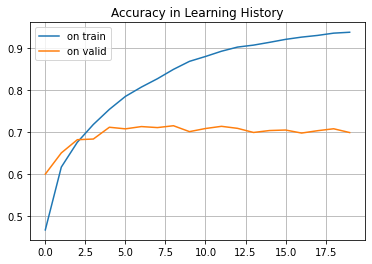

In [0]:
plt.plot(history_mn.history['acc'], label='on train')
plt.plot(history_mn.history['val_acc'], label='on valid')
plt.title('Accuracy in Learning History')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [0]:
test_loss, test_acc = model_mn.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 114us/sample - loss: 1.5363 - acc: 0.6908


*Доля правильных ответов на тесте с увеличением количества нейронов увеличилась к 69%. Тем не менее, она сильно выросла и на обучающей выборке - что говорит о некотором переобучении сети.*

*Попробуем далее увеличить глубину сети, добавив еще один блок со свёрточными слоями.*

## Увеличение глубины сети

Первый блок генерации признаков:
 - первый свёрточный слой: 32 фильтров 3х3 (индекс 0)
 - второй свёрточный слой: 32 фильтров 3х3 (индекс 1)
 - слой пулинга через взятие максимума фильтром 2х2
 - слой дропаута для регуляризации весов

Второй блок генерации признаков:
 - третий свёрточный слой: 64 фильтров 3х3 (индекс 4)
 - четвёртый свёрточный слой: 64 фильтров 3х3 (индекс 5)
 - слой пулинга через взятие максимума фильтром 2х2
 - слой дропаута для регуляризации весов

Блок классификации:
 - два полносвязных слоя по 256 (было 64) нейрона
 - слой дропаута для регуляризации весов 
 - выходной слой с 10 нейронами

In [0]:
model_ml = Sequential(name='model_ml')

model_ml.add(Conv2D(filters=32,
                    kernel_size=(3, 3),
                    activation='relu', 
                    input_shape=(32, 32, 3),
                    padding='valid',                    
                    data_format='channels_last',
                    name='conv_1'))
model_ml.add(Conv2D(filters=32,
                    kernel_size=(3, 3),
                    activation='relu',
                    data_format='channels_last',
                    name='conv_2'))
model_ml.add(MaxPooling2D(pool_size=(2, 2),
                          data_format='channels_last',
                          name='pool_1'))
model_ml.add(Dropout(rate=0.3, seed=0, name='drop_1'))

model_ml.add(Conv2D(filters=64,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    padding='valid',
                    data_format='channels_last',
                    name='conv_3'))
model_ml.add(Conv2D(filters=64,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    activation='relu',
                    data_format='channels_last',
                    name='conv_4'))
model_ml.add(MaxPooling2D(pool_size=(2,2),
                          strides=(1, 1),
                          data_format='channels_last',
                          name='pool_2'))
model_ml.add(Dropout(rate=0.3, seed=0, name='drop_2'))

model_ml.add(Flatten(name='flatten'))
model_ml.add(Dense(256, activation='relu', name='dense_1'))
model_ml.add(Dense(256, activation='relu', name='dense_2'))
model_ml.add(Dropout(rate=0.3, seed=0, name='drop_3'))

model_ml.add(Dense(10, activation='softmax', name='output'))

In [0]:
model_ml.summary()

Model: "model_ml"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 32)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 14, 14, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 10, 10, 64)        36928     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 9, 9, 64)          0  

In [0]:
model_ml.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [0]:
history_ml = model_ml.fit(x_train, y_train,
                          batch_size=40,
                          epochs=20,
                          validation_split=0.1,
                          use_multiprocessing=True,
                          verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 10s 218us/sample - loss: 1.5824 - acc: 0.4170 - val_loss: 1.1864 - val_acc: 0.5702
Epoch 2/20
45000/45000 [==============================] - 9s 198us/sample - loss: 1.1825 - acc: 0.5819 - val_loss: 0.9933 - val_acc: 0.6528
Epoch 3/20
45000/45000 [==============================] - 9s 199us/sample - loss: 1.0188 - acc: 0.6443 - val_loss: 0.9645 - val_acc: 0.6596
Epoch 4/20
45000/45000 [==============================] - 9s 200us/sample - loss: 0.9140 - acc: 0.6805 - val_loss: 0.8246 - val_acc: 0.7118
Epoch 5/20
45000/45000 [==============================] - 9s 201us/sample - loss: 0.8351 - acc: 0.7062 - val_loss: 0.8217 - val_acc: 0.7156
Epoch 6/20
45000/45000 [==============================] - 9s 199us/sample - loss: 0.7762 - acc: 0.7247 - val_loss: 0.7728 - val_acc: 0.7278
Epoch 7/20
45000/45000 [==============================] - 9s 200us/sample - loss: 0.7307 - acc: 0.7435 - val_l

**Проверка модели**

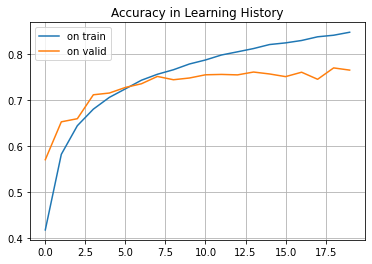

In [0]:
plt.plot(history_ml.history['acc'], label='on train')
plt.plot(history_ml.history['val_acc'], label='on valid')
plt.title('Accuracy in Learning History')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [0]:
test_loss, test_acc = model_ml.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 119us/sample - loss: 0.8554 - acc: 0.7510


*Доля правильных ответов на тесте с увеличением глубины сети увеличилась до 75%. При этом, хотя количество нейронов не меньше, чем в прошлый раз (+ добавились нейроны нового блока), эффект переобучения мал.*

*Таким образом, подтверждается то, что увеличение глубины CNN может давать модели прирост качества. Однако слои. конечно, следует добавлять аккуратно.*

**Сохранение весов последней модели**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_model.save_weights('/content/drive/My Drive/base_model.h5')
model_mn.save_weights('/content/drive/My Drive/model_mn.h5')
model_ml.save_weights('/content/drive/My Drive/model_ml.h5')

## Работа слоёв свёртки

**Возьмём в качестве примера первое тестовое изображение:**

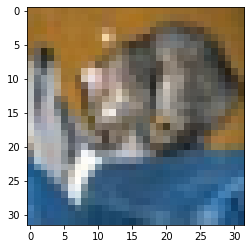

In [0]:
plt.imshow(test_images[0])
plt.show()

**Вырежем из последней сети первый слой свёртки:**

In [0]:
# Индекс 0
conv_1 = Model(inputs=model_ml.input, outputs=model_ml.layers[0].output, name='conv_1')
conv_1.summary()

Model: "conv_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________


**Пропустим пример изображения через первые 16 фильтров вырезанного первого слоя:**

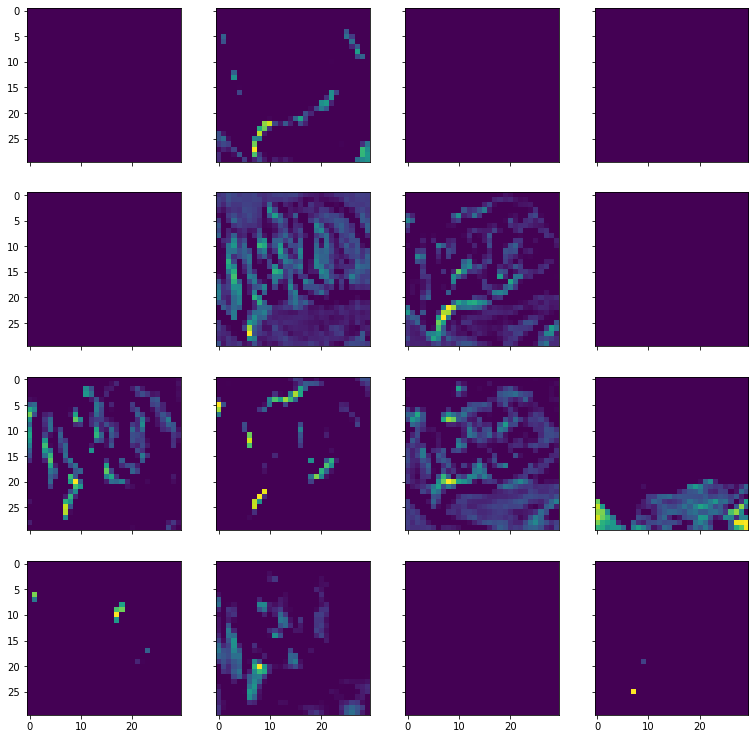

In [0]:
conv1_features = conv_1.predict(x_test[0].reshape(1, 32, 32, 3))

fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(13, 13))
for i, ax in enumerate(axes.flatten()):
    image = conv1_features[0, :, :, i] * 255
    ax.imshow(image, cmap='viridis')

*Поскольку слой первый, видна пока ещё достаточно высокая детализация изображения. Кое-где прослеживаются артефакты исходного изображения*.

**Вырежем из сети предпоследний слой свёртки:**

In [0]:
# Индекс 4
conv_4 = Model(inputs=model_ml.input, outputs=model_ml.layers[4].output, name='conv_4')
conv_4.summary()

Model: "conv_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_input (InputLayer)    [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 32)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 14, 14, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 64)        18496     
Total params: 28,640
Trainable params: 28,640
Non-trainable params: 0
________________________________________________________

**Пропустим пример изображения через первые 16 фильтров вырезанного предпоследнего слоя:**

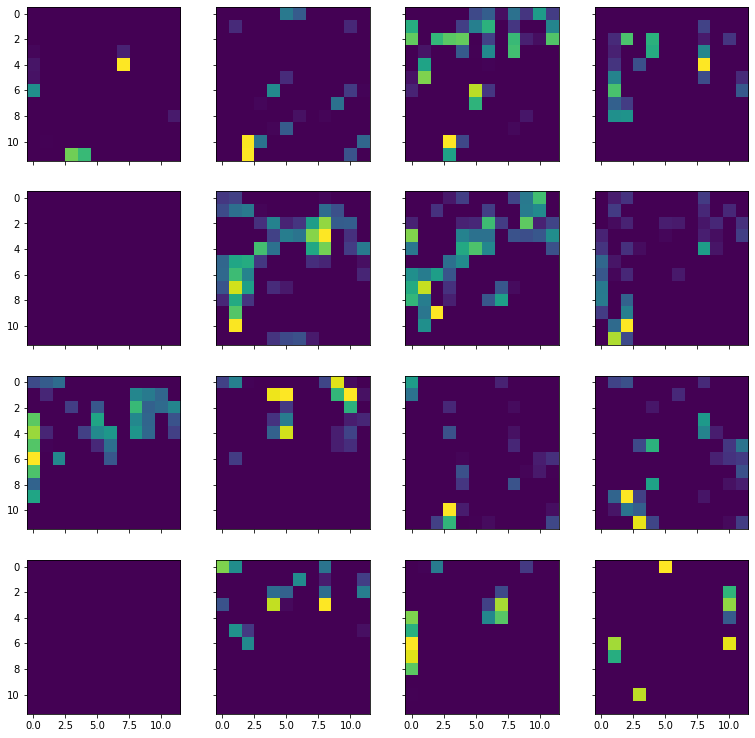

In [0]:
conv4_features = conv_4.predict(x_test[0].reshape(1, 32, 32, 3))

fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True, figsize=(13, 13))
for i, ax in enumerate(axes.flatten()):
    image = conv4_features[0, :, :, i] * 255
    ax.imshow(image, cmap='viridis')

*Заметна повысившаяся с увеличением глубины сети пикселизация получаемых результатов. Это можно проинтерпретировать как ещё большее обобщение получаемых результатов свёртки - т.е. новых снегерированных признаков, которые потом пойдут на слой классификаци - что и обеспечивает прирост качества сети на не известных ей изображениях. Тем не менее, увеличение её глубины тоже следует контролировать (например, анализом и проверкой её работы, а также регуляризацией).*